In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

In [7]:
x = df.drop('energy', axis=1)
y = df['energy']


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [9]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [13]:
from sklearn.dummy import DummyRegressor

In [14]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [16]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  9867987602848.395
The dummy's mse:  58655562604453.83
Relative error:  0.16823617683788272


In [17]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)


The model's r2:  0.8317424074709598
The dummy's r2:  -0.00012729539840949933


In [18]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2196948.915209919
The dummy's mae:  6459502.394547132
Relative error:  0.3401111697186614


In [19]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")
    
 



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       9867987602848.395    58655562604453.828   0.168     
R2                        0.832                -0.000               -6533.955 
MAE                       2196948.915          6459502.395          0.340     
Ratio of mae over mean value of y: 0.130


#### Let's also look at the residuals to see if there are any patterns.


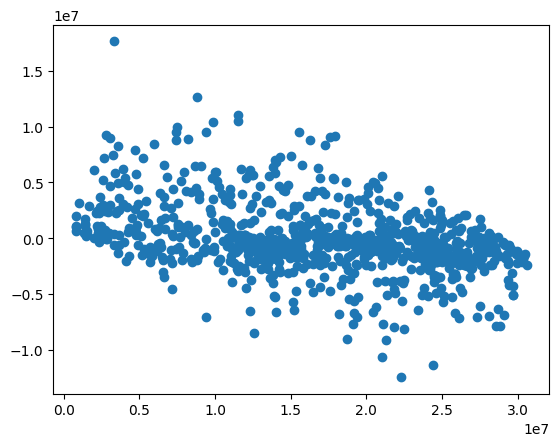

In [20]:
plt.scatter(y_test, y_pred - y_test)
# plt.scatter(y_test, y_pred_dummy - y_test)
plt.show()

# That was the Holdout Method, now do K-Fold Cross Validation

## Pt.2 Hyper parameter tuning with cross validation

In [57]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
# cv = KFold(n_splits=3, shuffle=True, random_state=56)

# Because these take a while to train we are going straight into HPO


# Define the search space for the random forest hyperparameters.

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 100)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 50)]
min_samples_split = [2, 3, 4, 5, 6, 7, 10, 13, 14, 15, 18, 20]
min_samples_leaf = [1, 2, 3, 4, 6, 8]




param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf    
    
}




rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 400, cv = 3, verbose=2, random_state=56, n_jobs = -1, scoring='neg_mean_absolute_error')


rf_random.fit(X_train, y_train) 



print(f"{'The best parameters are: '}", rf_random.best_params_)
print(f"{'The best MAE score attained was: '}", -rf_random.best_score_)



Fitting 3 folds for each of 400 candidates, totalling 1200 fits
The best number of neighbors when using negative mean absolute error scoring is:  {'n_estimators': 720, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 16}
The best MAE score attained was:  2125951.299093535


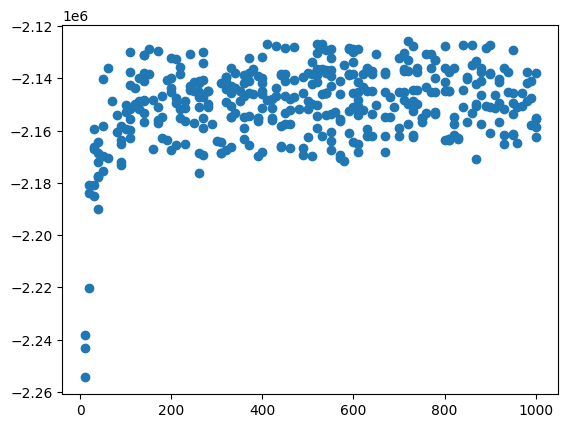

In [63]:
new_frame = pd.DataFrame(rf_random.cv_results_)[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
# print(new_frame.head(10))

# print out all of the n_estimators that were tried
print()

# make a plot with the mean test score on the y axis and n_estimators on the x axis, repeat for other parameters
plt.scatter( new_frame['params'].apply(lambda x: x['n_estimators']),new_frame['mean_test_score'])
plt.show()


In [65]:
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(2129726.236749123/np.mean(y)*100):.2f}", '%')
# rf_random.fit(X_train, y_train)

# final_rf = RandomForestRegressor(n_estimators=500, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', max_depth=90, random_state=56) # 2128904.917
# final_rf = RandomForestRegressor(n_estimators=230, min_samples_split=2, min_samples_leaf=3, max_features='sqrt', max_depth=70, random_state=56) # 2127209.801833643
# final_rf = RandomForestRegressor(n_estimators=890, min_samples_split=4, min_samples_leaf=3, max_features='sqrt', max_depth=60, random_state=56) # 2127118.211464582
final_rf = RandomForestRegressor(n_estimators=720, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', max_depth=16, random_state=56) # 2125951.299093535




final_rf.fit(X_train, y_train)
rf_pred = final_rf.predict(X_test)


my_scores = []


mse_values = ["MSE"]
mse = mean_squared_error(y_test, rf_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)



r2_values = ["R2"]
r2 = r2_score(y_test, rf_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)



mae_values = ["MAE"]
mae = mean_absolute_error(y_test, rf_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)


print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")


Average MAE scores with HPO as a percentage of the mean y value:  12.62 %
Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       9223980152669.268    58655562604453.828   0.157     
R2                        0.843                -0.000               -6620.218 
MAE                       2134496.484          6459502.395          0.330     
Ratio of mae over mean value of y: 0.127


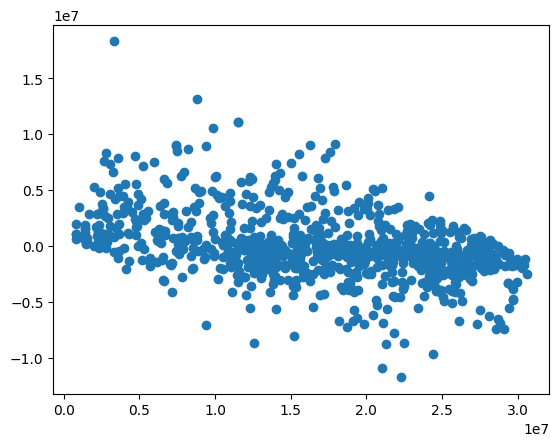

In [64]:
plt.scatter(y_test, rf_pred - y_test)
# plt.scatter(y_test, y_pred_dummy - y_test)
plt.show()